# Tarea PySpark

### Objetivo:
 Analizar la eficiencia de los jugadores en términos generales y por posición, así como determinar la contribución al equipo por jugador tomando en cuenta los datos obtenidos

Usarás la base de datos del archivo 'fusbol.csv' para obtener tus datos. Checa la estructura del archivo para ver si es necesario limpiar la informacion, ver su estructura y así sea más fácil completar la tarea. Besos.

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName('firstSession')\
    .config('spark.master', 'local[2]')\
    .config('spark.executor.memory', '1g')\
    .config("spark.sql.shuffle.partitions", 10)\
    .config('spark.driver.memory','1g')\
    .getOrCreate()

In [6]:
df_c = spark.read.csv('fusbol.csv', header=True, inferSchema=True)
df_c.toPandas().head()

,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,...,PrgDistCarry/90,ProgCarry/90,CarryIntoThird/90,CarryIntoBox/90,Miscontrol/90,Dispossessed/90,PassTarget/90,PassesReceived/90,PassRec%,ProgPassReceived/90
0,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,29.0,1990.0,22,20,1777,...,96.8,5.79,1.52,0.46,0.66,0.81,42.3,39.3,92.8,2.34
1,Yunis Abdelhamid,ma MAR,DF,Reims,fr Ligue 1,32.0,1987.0,33,33,2889,...,130.5,1.81,0.25,0.03,0.25,0.47,43.8,42.5,97.0,0.22
2,Pape Abou Cisse,sn SEN,DF,Saint-Étienne,fr Ligue 1,24.0,1995.0,14,14,1260,...,117.9,1.14,0.07,0.00,0.14,0.07,33.7,32.9,97.7,0.00
3,David Abraham,ar ARG,DF,Eint Frankfurt,de Bundesliga,34.0,1986.0,14,14,1222,...,92.7,3.24,0.66,0.00,0.22,0.00,34.8,33.4,96.0,0.59
4,Francesco Acerbi,it ITA,DF,Lazio,it Serie A,32.0,1988.0,32,32,2813,...,166.3,3.71,1.02,0.03,0.45,0.26,50.9,49.5,97.3,0.70


### Ejercicio 1:
Carga la base de datos en un DataFrame de Pyspark (con 2 nucleos). Valida los rangos de los valores donde sea aplicable, así como su corrección (en caso de ser necesaria). 
Después, utilizando las variables más relevantes como 'Ast/90', 'PassCmp%', etc., concluye qué ligas tienen los mejores jugadores por posición. Es decir, si los mejores jugadores defensas son de la liga francesa, inglesa, etc., por ejemplo.
Como cada persona tiene una definición de "mejor", utiliza las siguientes metricas por posición:
- Delanteros: npG+A/90 y npxG+xA/90
- Medios: KeyPass/90 y PassCmp%
- Defensas: PressSucc% y Interceptions/90

Con los resultados obtenidos, grafica por posición para que tu conclusión tenga un respaldo visual también.

In [54]:
from pyspark.sql.functions import col, avg, split, explode

df = df_c.select(['Player', 'Nation', 'Squad', 'Comp', 'Pos', 'npG+A/90', 'npxG+xA/90', 'KeyPass/90', 'PassCmp%', 'PressSucc%', 'Interceptions/90']).dropna()
df_split = df.withColumn('Pos', split(df['Pos'], ','))
df = df_split.withColumn('Pos', explode(df_split['Pos']))

df_df = df.select(['Comp', 'Pos', 'PressSucc%', 'Interceptions/90']).filter(df['Pos']=='DF')
df_mf = df.select(['Comp', 'Pos', 'KeyPass/90', 'PassCmp%']).filter(df['Pos']=='MF')
df_fw = df.select(['Comp', 'Pos', 'npG+A/90', 'npxG+xA/90']).filter(df['Pos']=='FW')

df_df = df_df.groupBy('Comp').agg(avg('PressSucc%'), avg('Interceptions/90'))
df_mf = df_mf.groupBy('Comp').agg(avg('KeyPass/90'), avg('PassCmp%'))
df_fw = df_fw.groupBy('Comp').agg(avg('npG+A/90'), avg('npxG+xA/90'))

In [55]:
df_df.show()
df_mf.show()
df_fw.show()

+------------------+------------------+---------------------+
|              Comp|   avg(PressSucc%)|avg(Interceptions/90)|
+------------------+------------------+---------------------+
|eng Premier League| 31.02336448598129|   1.1732242990654205|
|        es La Liga| 31.31402714932125|    1.175475113122172|
|        it Serie A|31.600806451612915|   1.2622983870967743|
|        fr Ligue 1| 33.76796116504854|    1.352718446601942|
|     de Bundesliga|32.957971014492756|   1.3462318840579706|
+------------------+------------------+---------------------+

+------------------+------------------+-----------------+
|              Comp|   avg(KeyPass/90)|    avg(PassCmp%)|
+------------------+------------------+-----------------+
|eng Premier League|0.9622374429223747|79.48401826484015|
|        es La Liga|1.0096864111498256|76.33170731707321|
|        it Serie A|1.2307171314741037|79.52988047808765|
|        fr Ligue 1|0.9809489051094894|78.70437956204377|
|     de Bundesliga|1.0874336283185

Los mejores defensas están en la liga francesa, los mejores medios en la italiana y los mejores delanteros en la italiana.

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

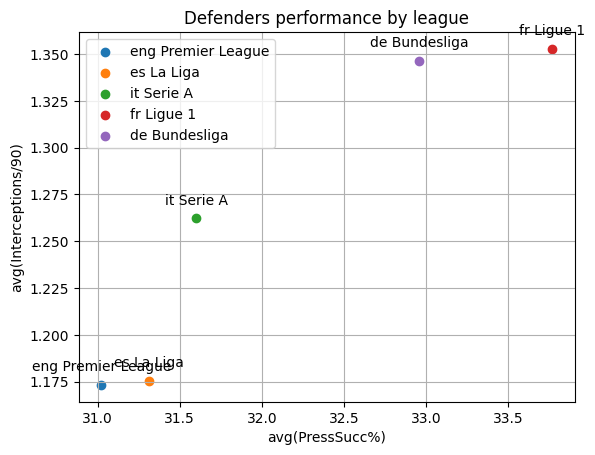

In [46]:
import matplotlib.pyplot as plt

df_df_ = df_df.toPandas()
x = 'avg(PressSucc%)'
y = 'avg(Interceptions/90)'

fig, ax = plt.subplots()
for label, values in df_df_.iterrows():
    ax.scatter(values[x], values[y], label=values['Comp'])
    ax.annotate(values['Comp'], (values[x], values[y]), textcoords="offset points", xytext=(0,10), ha='center')

# Set plot title and labels
plt.title('Defenders performance by league')
plt.xlabel(x)
plt.ylabel(y)

# Show legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

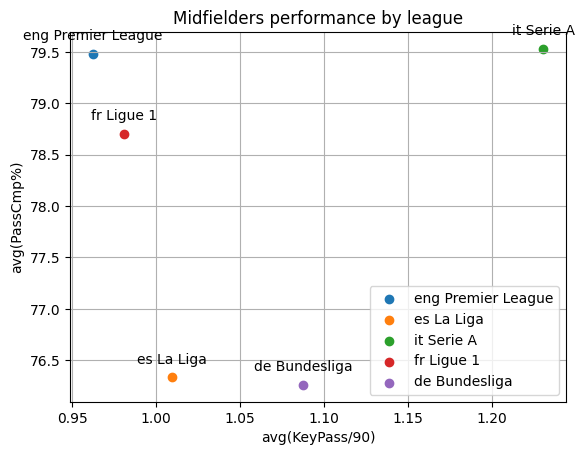

In [48]:
df_mf_ = df_mf.toPandas()
x = 'avg(KeyPass/90)'
y = 'avg(PassCmp%)'

fig, ax = plt.subplots()
for label, values in df_mf_.iterrows():
    ax.scatter(values[x], values[y], label=values['Comp'])
    ax.annotate(values['Comp'], (values[x], values[y]), textcoords="offset points", xytext=(0,10), ha='center')

# Set plot title and labels
plt.title('Midfielders performance by league')
plt.xlabel(x)
plt.ylabel(y)

# Show legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

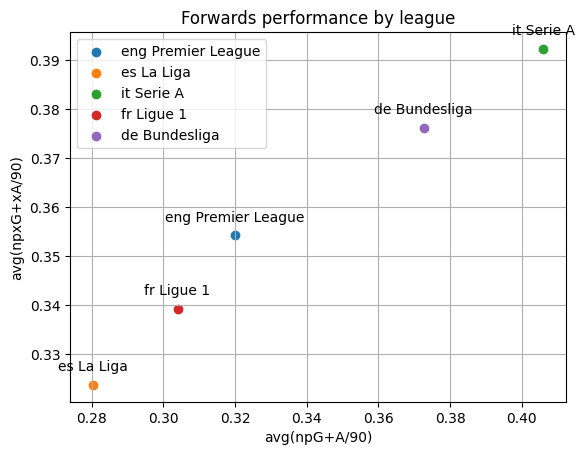

In [50]:
df_fw_ = df_fw.toPandas()
x = 'avg(npG+A/90)'
y = 'avg(npxG+xA/90)'

fig, ax = plt.subplots()
for label, values in df_fw_.iterrows():
    ax.scatter(values[x], values[y], label=values['Comp'])
    ax.annotate(values['Comp'], (values[x], values[y]), textcoords="offset points", xytext=(0,10), ha='center')

# Set plot title and labels
plt.title('Forwards performance by league')
plt.xlabel(x)
plt.ylabel(y)

# Show legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

### Ejercicio 2:

Ahora hagamos algo un poco más interesante. Escoge algún jugador de todos los disponibles y toma 5 metricas, las que quieras. Debes concluir en qué percentil se encuentra el jugador en esas métricas que escogiste. Obviamente, vas a comparar sus valores con todos los demás con los que comparte posición y liga, para no tener un sesgo y que la información no pierda robustez. Por último, genera un DataFrame de Pyspark con todos los datos solicitados. Muestra el DataFrame y conviertelo a otro de tipo pandas. Muestra los dos.

In [80]:
sterling = df.filter(df['Player']=='Raheem Sterling').select(['Player', 'Comp', 'Pos', 'npG+A/90', 'npxG+xA/90', 'KeyPass/90', 'PassCmp%', 'Interceptions/90'])
sterling.show()

+---------------+------------------+---+--------+----------+----------+--------+----------------+
|         Player|              Comp|Pos|npG+A/90|npxG+xA/90|KeyPass/90|PassCmp%|Interceptions/90|
+---------------+------------------+---+--------+----------+----------+--------+----------------+
|Raheem Sterling|eng Premier League| FW|     0.6|      0.58|      1.35|    85.4|             0.5|
+---------------+------------------+---+--------+----------+----------+--------+----------------+



In [128]:
from scipy.stats import percentileofscore

df2 = df.filter((df['Player']!='Raheem Sterling') & (df['Pos']=='FW')).filter(df['Comp']=='eng Premier League').select(['npG+A/90', 'npxG+xA/90', 'KeyPass/90', 'PassCmp%', 'Interceptions/90'])

print('Raheem Sterling: percentile against forwards in Premier League', '\n')

for col in df2.columns:
    percentile = percentileofscore(df2.select(col).rdd.flatMap(lambda x: x).collect(), sterling.toPandas()[col].loc[0])
    print(col)
    print(percentile, '\n')

Raheem Sterling: percentile against forwards in Premier League 

npG+A/90
86.12716763005781 

npxG+xA/90
87.86127167630059 

KeyPass/90
71.09826589595376 

PassCmp%
93.0635838150289 

Interceptions/90
47.10982658959538 

